# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Note: there may be minor differences between the output of this notebook and the examples shown in the book. You can safely ignore these differences. They are mainly due to the fact that most of the environments provided by OpenAI gym have some randomness.

# A simple environment: the Cart-Pole

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [2]:
import gym
env = gym.make("CartPole-v0")

In [3]:
obs = env.reset()

In [4]:
obs

array([ 0.00812385,  0.049357  , -0.01360323,  0.03378451])

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. Let's render the environment... unfortunately we need to fix an annoying rendering issue first.

## Fixing the rendering issue

Some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify the `rgb_array` mode. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like Xvfb. You can start Jupyter using the `xvfb-run` command:

    $ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

If Jupyter is running on a headless server but you don't want to worry about Xvfb, then you can just use the following rendering function for the Cart-Pole:

In [5]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    

<IPython.core.display.Javascript object>


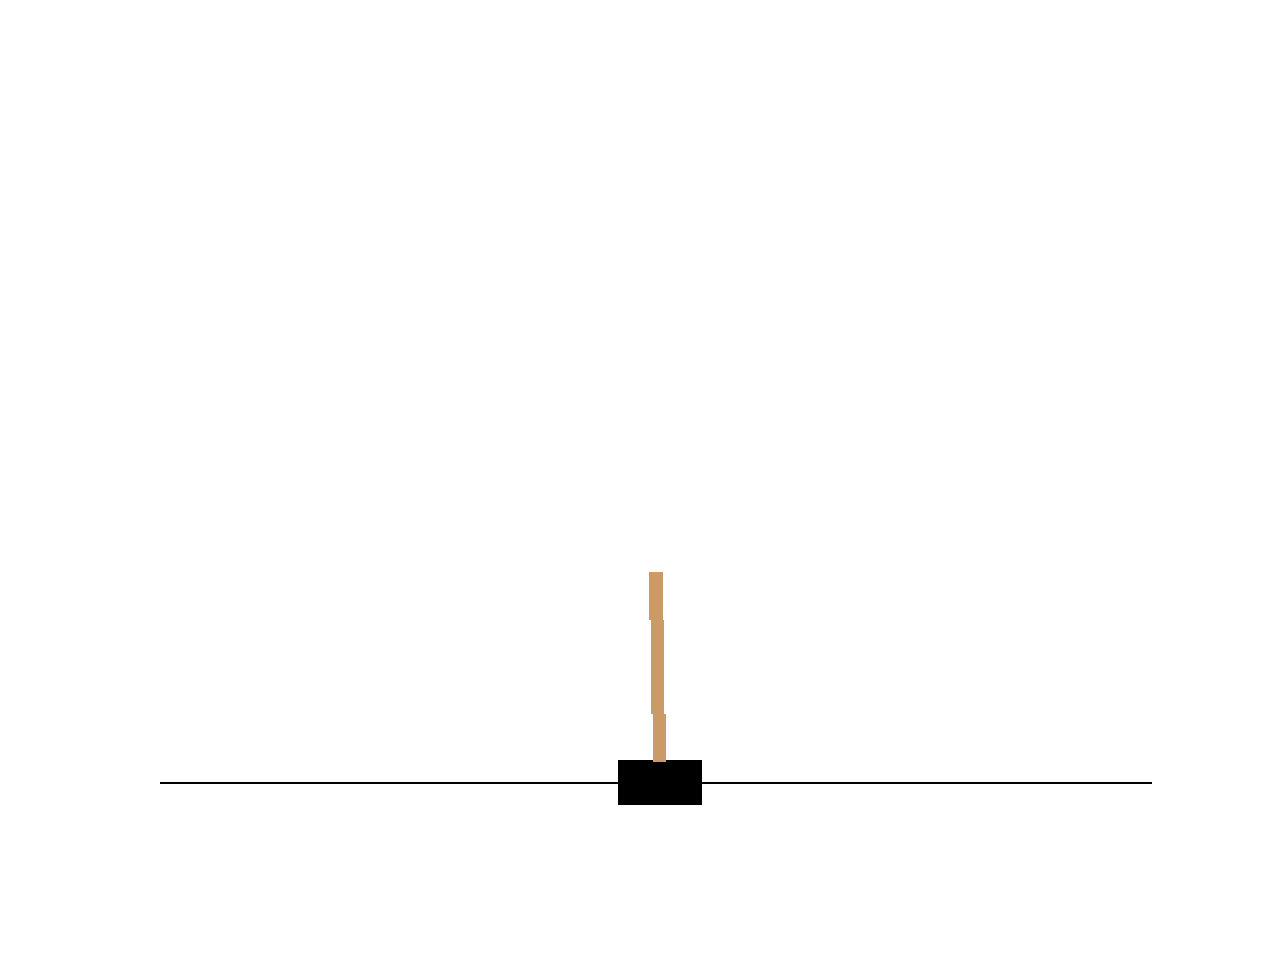

In [6]:
plot_cart_pole(env, obs)

Now let's look at the action space:

In [7]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [8]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


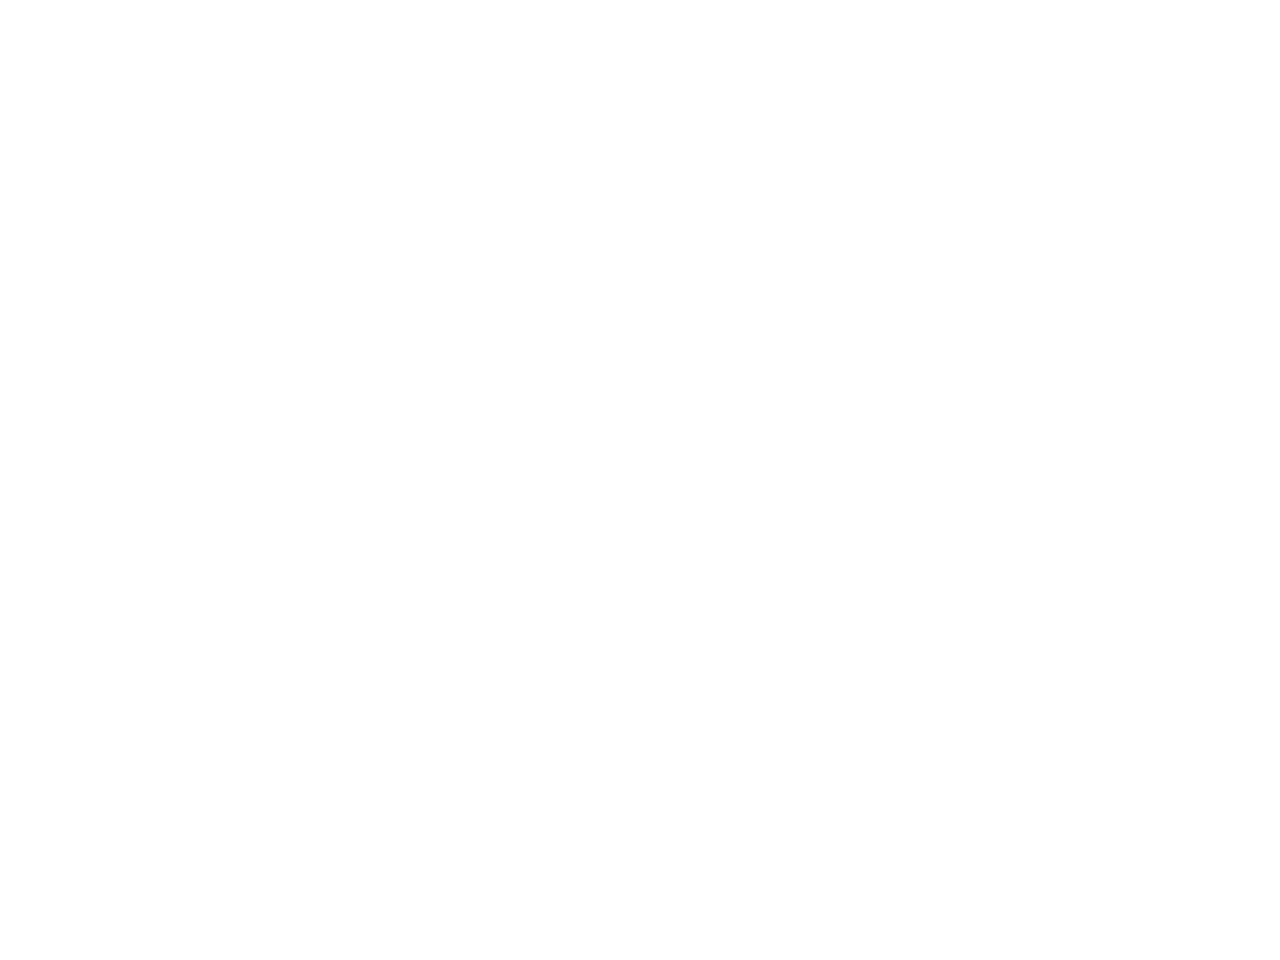

Saving figure cart_pole_plot


FileNotFoundError: [Errno 2] No such file or directory: './images/cart_pole_plot.png'

In [9]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
save_fig("cart_pole_plot")

In [10]:
img.shape

(400, 600, 3)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [11]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


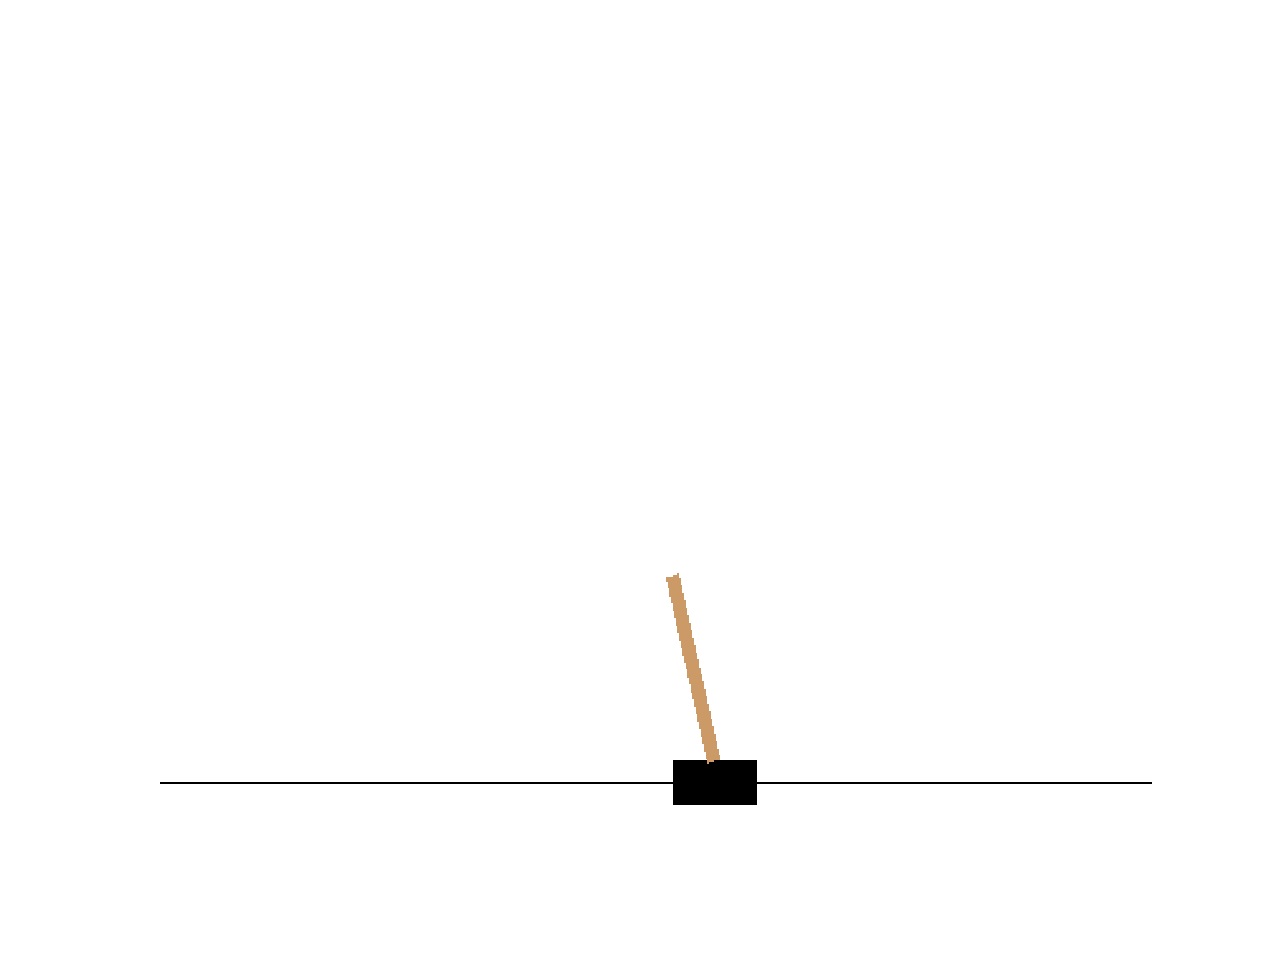

In [12]:
plot_cart_pole(env, obs)

Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a _policy_ for that. We did this in the previous notebook using both a hard-coded and neural network policy. Now let's try using policy gradients to do this instead.

# Policy Gradients

To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.

We will be implementing a variant of the REINFORCE algorithm that we saw in class previously. The steps are as follows:

1. First, let the neural network policy play the game several times and at each stepcompute the gradients that would make the chosen action even more likely, but don’t apply these gradients yet.

2. Once you have run several episodes, compute each action’s score (using the method described in the previous paragraph).

3. If an action’s score is positive, it means that the action was good and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the score is negative, it means the action was bad and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the corresponding action’s score.

4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a Gradient Descent step.

In [13]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# define target probability:
# Since we are acting as though the chosen
# action is the best possible action, the target probability must be 1.0 if the chosen
# action is action 0 (left) and 0.0 if it is action 1 (right):
y = 1. - tf.to_float(action) 

# define cost function (cross entropy) and compute the gradients
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy) # note here we compute gradients instead of minimize

gradients = [grad for grad, variable in grads_and_vars] # put all gradients in list for easy access

# set placeholders for updated gradient vectors, and create operation to apply updated gradients
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.


On to the execution phase! We will need a couple of functions to compute the total
discounted rewards, given the raw rewards, and to normalize the results across multi‐
ple episodes:

In [14]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [15]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [16]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

We now have all we need to train the policy:

In [18]:
env = gym.make("CartPole-v0")

n_games_per_update = 10 # train the policy every 10 episodes
n_max_steps = 1000      # max steps per episode
n_iterations = 25      # number of training iterations
save_iterations = 10    # save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []   # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = []    # all raw rewards from the current episode
            current_gradients = []  # all gradients from the current episode
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 24

In [19]:
env.close()

In [20]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [21]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


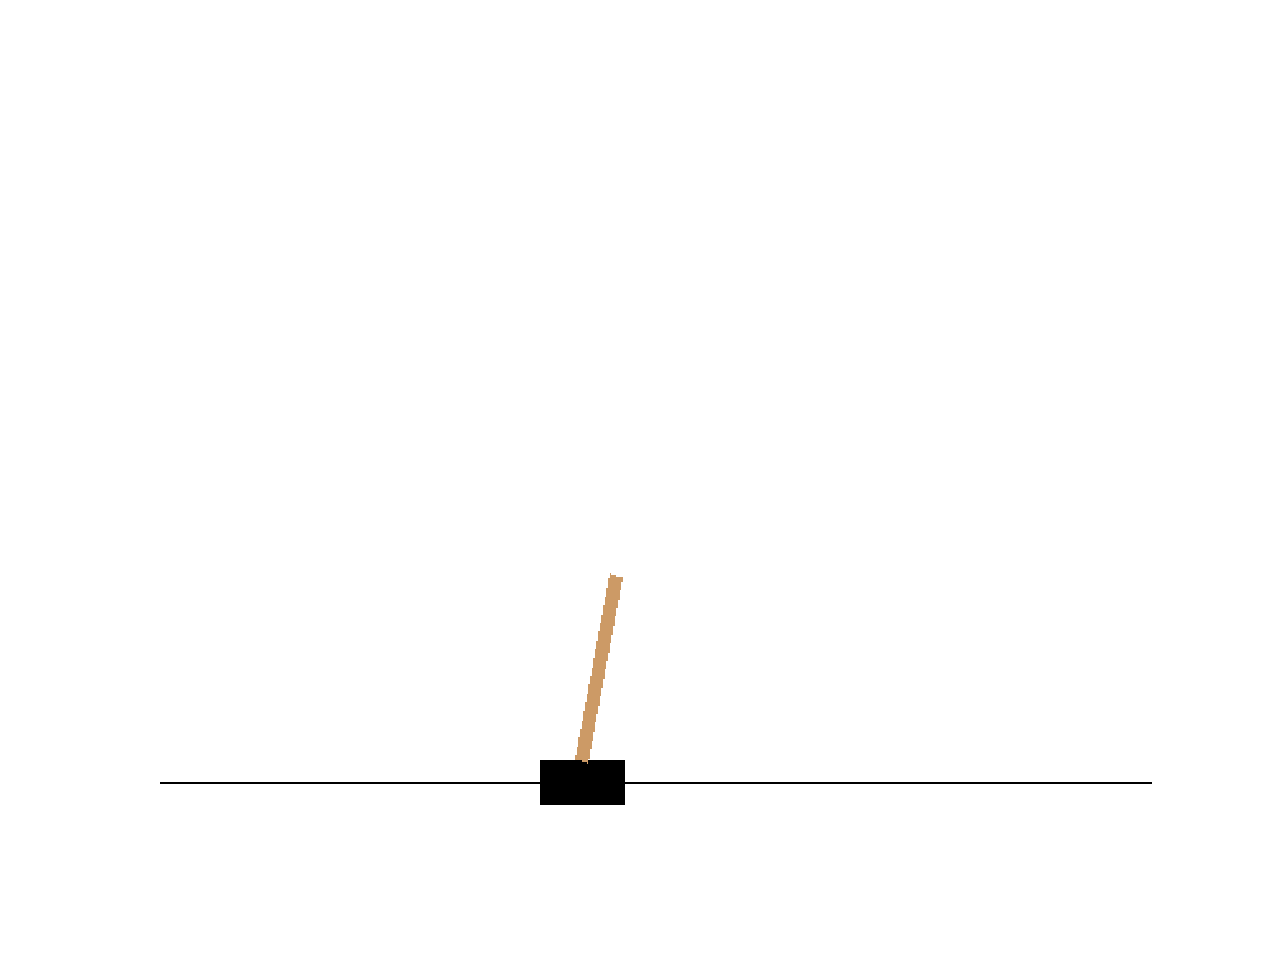

In [22]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

**Question:** How well does this method do compared to the hard coded and neural network policies from the last notebook?